In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools
import utils
from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path
from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id


from data_analysis.tools import curr2cond, smooth

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 9.11e-31
h = 6.623e-34
h_bar = h/(2*np.pi)
e = 1.602e-19
E_F = 100e-3*e #J
m_eff = 0.023*m

v_F = np.sqrt(2*E_F/m_eff)

G0 = 2*e**2/h

In [3]:
from utils.utils import dic_data
from utils.utils.dic_data import dic2hdf5, data
import scipy.optimize as spy

### Load data file and visualize parameters

In [32]:
dat1 = load_by_id(321)

In [5]:
dat1.get_parameters()

[ivvi_dac1 (numeric),
 raw_voltage (numeric),
 current (numeric),
 leakage_voltage (numeric)]

### 1D plot

In [37]:
def plot1D(data, x, y):
    x_ax = np.unique(np.array(data.get_values(x))) #[::-1]
    i = np.array(data.get_values(y))
    i = -i[:,0]
    #i = smooth(i, 31, 3)
    #g_sub = curr2cond(i, 20e-6, 16.4e3)
    plt.figure()
    plt.plot(x_ax, np.log10(abs(i))) #, label=x2+' = '+str(x2_value*10)+'mV')
    plt.xlabel(x+' (V)')
    #plt.ylabel('dI/dV (G0)')
    plt.legend()
    #return b #, g_sub

<IPython.core.display.Javascript object>


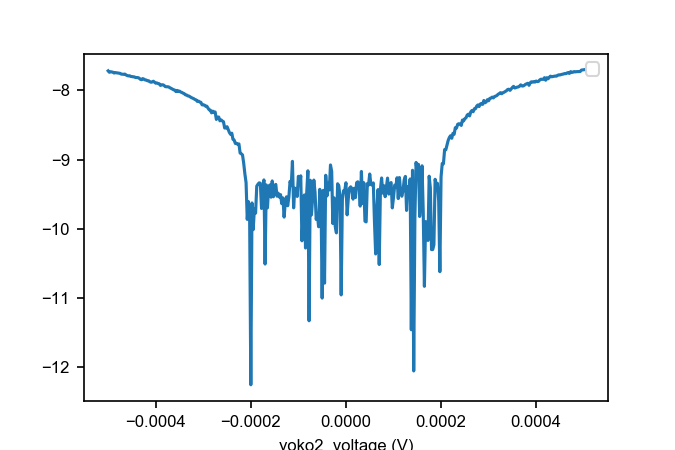

No handles with labels found to put in legend.


In [31]:
plot1D(dat1, "yoko2_voltage", "current")

<IPython.core.display.Javascript object>


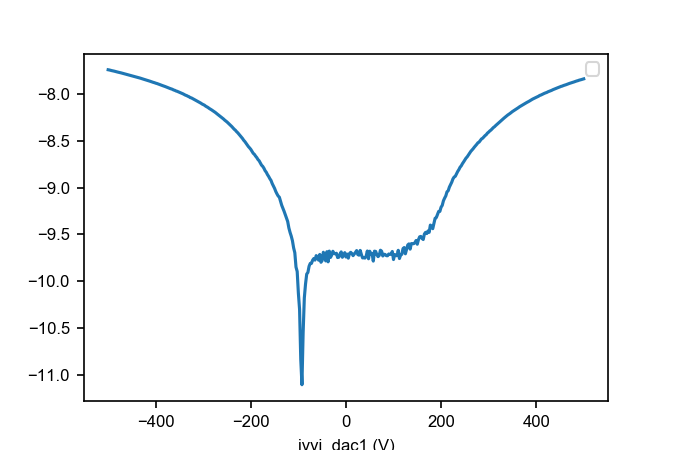

No handles with labels found to put in legend.


In [38]:
plot1D(dat1, "ivvi_dac1", "current")

<IPython.core.display.Javascript object>


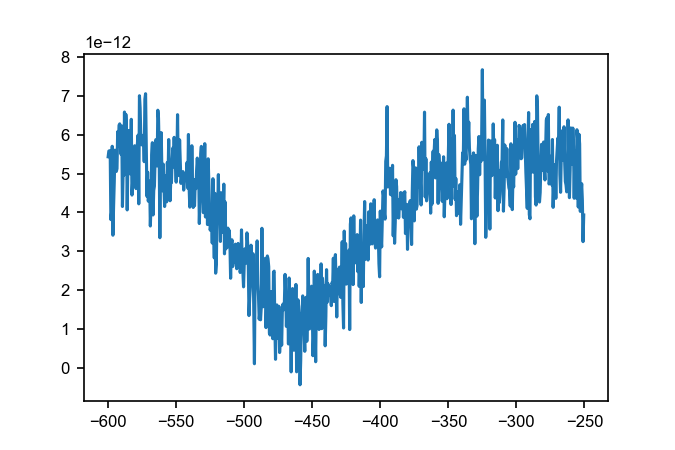

In [167]:
pltBiasAxis = np.array(dat1.get_values('ivvi_dac1'))[:701]
pltGateAxis = np.array(dat1.get_values('ivvi_dac3'))[::701]
pltCurrent = np.array(dat1.get_values('current')).reshape(201,701)
for count in range(0,200):
    pltCurrent[count,:] = smooth(pltCurrent[count,:], 11, 1)
pltConductance = pltCurrent[:,1:]-pltCurrent[:,:-1]
plt.figure('test_1D')
plt.plot(pltBiasAxis[:-1], pltConductance[26,:])

<IPython.core.display.Javascript object>


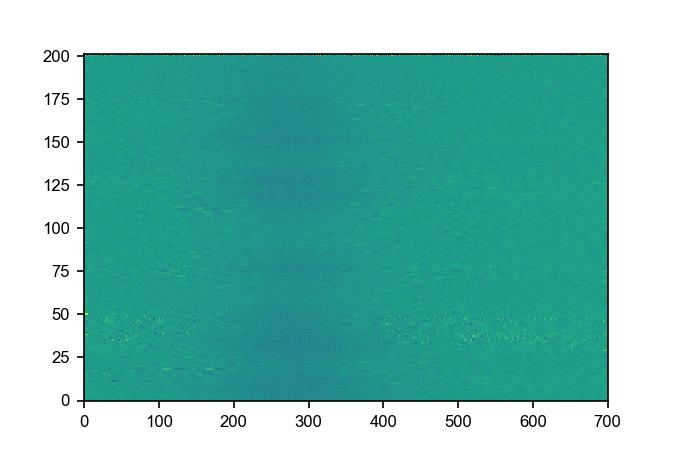

In [164]:
plt.figure('test_2D')
plt.pcolor(pltConductance)

In [108]:
plot1D(dat1, 'ivvi_dac1', 'current')

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (701,) and (140901,)

### 2D plot

In [102]:
def colorplot(data, fast_s, slow_s, z, cond='True'):
    fig=plt.figure()
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    print(len(ss))
    z1 = np.array(data.get_values(z))
    print(min(np.unique(z1)),max(np.unique(z1)))
    #z1*=1e13
    if cond:
        r_line = 15e3
        bias = 20e-6
        z1 = bias/z1
        z1 = (1/(z1 - r_line))/G0
    cmap = plt.cm.seismic #seismic, viridis, magma
    #norm = mpl.colors.Normalize(vmin=min(np.unique(z1)), vmax=max(np.unique(z1)))  #vmin=min(np.unique(z1)), vmax=max(np.unique(z1))    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    norm = mpl.colors.Normalize(vmin=0,vmax=1e3)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('I')
    plt.contourf(np.unique(fs)[::-1], np.unique(ss)[::-1], np.reshape(z1,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap,
                vmin=min(np.unique(z1)), vmax=max(np.unique(z1)))
    plt.xlabel(fast_s + ' (10mV/V)')
    plt.ylabel(slow_s + ' (V)')
    return np.unique(fs)[::-1], np.unique(ss)[::-1], np.reshape(z1,(len(np.unique(ss)),len(np.unique(fs))))

In [103]:
fs,ss,z = colorplot(dat1, 'ivvi_dac1', 'ivvi_dac3', 'current', cond='False')

<IPython.core.display.Javascript object>

201
-1.09387071e-09 2.2548541e-09


NameError: name 'sm' is not defined

In [98]:
plt.figure()
plt.contourf(fs,ss,z)

dx = np.ediff1d(fs, to_end=0)
print(np.unique(dx))
dy = np.gradient(z,-0.5,axis=1)
cmap = plt.cm.seismic #seismic, viridis, magma
norm = mpl.colors.Normalize(vmin=min(np.unique(dy)), vmax=max(np.unique(dy)))
X,Y = np.meshgrid(fs,ss)
plt.figure()
plt.contourf(fs,ss,dy, norm='Normalize')

<IPython.core.display.Javascript object>

[-0.5  0. ]


<IPython.core.display.Javascript object>

AttributeError: 'str' object has no attribute 'autoscale_None'

### 1D from 2D plot

In [59]:
def plot1D_from_2D(data, x, y, x2, x2_value):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    v2 = np.array(data.get_values(x2))
    points = np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    plt.plot(b, g, label=x2+' = '+str(x2_value*10)+'mV')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    #return b #, g_sub

<IPython.core.display.Javascript object>


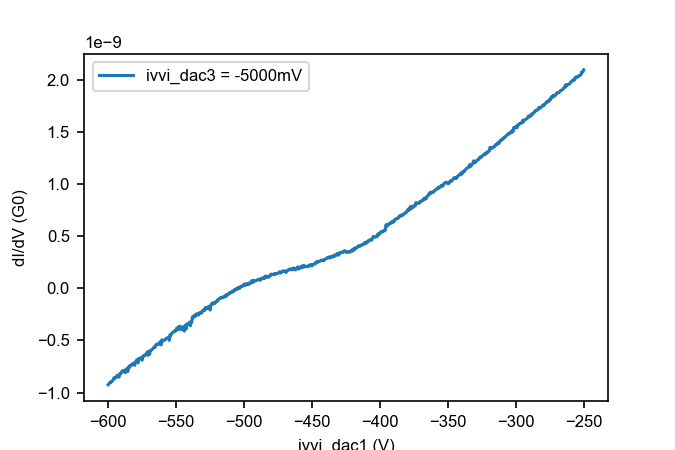

In [65]:
plt.figure()
plot1D_from_2D(dat1, 'ivvi_dac1', 'current', 'ivvi_dac3', -500)

In [62]:
plot1D_from_2D(dat1, 'gate_voltage', 'dI', 'bias_voltage', -450)

ValueError: Unknown parameter, not in this DataSet

### View gate or bias setpoints

In [61]:
np.unique(dat1.get_values('ivvi_dac1'))

array([-600. , -599.5, -599. , -598.5, -598. , -597.5, -597. , -596.5,
       -596. , -595.5, -595. , -594.5, -594. , -593.5, -593. , -592.5,
       -592. , -591.5, -591. , -590.5, -590. , -589.5, -589. , -588.5,
       -588. , -587.5, -587. , -586.5, -586. , -585.5, -585. , -584.5,
       -584. , -583.5, -583. , -582.5, -582. , -581.5, -581. , -580.5,
       -580. , -579.5, -579. , -578.5, -578. , -577.5, -577. , -576.5,
       -576. , -575.5, -575. , -574.5, -574. , -573.5, -573. , -572.5,
       -572. , -571.5, -571. , -570.5, -570. , -569.5, -569. , -568.5,
       -568. , -567.5, -567. , -566.5, -566. , -565.5, -565. , -564.5,
       -564. , -563.5, -563. , -562.5, -562. , -561.5, -561. , -560.5,
       -560. , -559.5, -559. , -558.5, -558. , -557.5, -557. , -556.5,
       -556. , -555.5, -555. , -554.5, -554. , -553.5, -553. , -552.5,
       -552. , -551.5, -551. , -550.5, -550. , -549.5, -549. , -548.5,
       -548. , -547.5, -547. , -546.5, -546. , -545.5, -545. , -544.5,
      